### exploratory data analysis

In [93]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, to_date, datediff, countDistinct, sum as _sum
from pyspark.sql.types import StringType
from sentence_transformers import SentenceTransformer, util
import pyspark as pysk
from collections import Counter
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import sklearn as skl
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns
# spark.stop()  # stop any already running 

In [80]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Read Cleaned Data") \
    .getOrCreate()


# Read the Parquet file into a DataFrame
s1clean = spark.read.parquet("online_retail_IIs1_clean.parquet/")
s2clean = spark.read.parquet("online_retail_IIs2_clean.parquet/")


### collect product description text

In [81]:
# Get unique product descriptions
unique_descriptions_s1 = s1clean.select("Description").distinct()
unique_descriptions_s2 = s2clean.select("Description").distinct()

# Combine unique descriptions from both sheets
unique_descriptions = unique_descriptions_s1.union(unique_descriptions_s2).distinct()

# Collect the unique descriptions to a list
unique_descriptions_list = [row['Description'] for row in unique_descriptions.collect()]
print(len(unique_descriptions_list))
# for sent in tqdm(unique_descriptions_list):
    # sent.replace('  ',' ')
    # sent.strip(',*')
print(unique_descriptions_list)


5207
['art lights,funk monkey', 'spotty home sweet home doormat', 'white retrodisc lampshade', 'french enamel pot w lid', 'new england ceramic cake server', 'purple bertie glass bead bag charm', 'crystal stud earrings assorted col', 'white rosebud pearl earrings', 'easter bunny garland flowers', 'tea cup saucer retro spot', 'regency cakestandtier', 'black bird garden design mug', 'candy spot egg warmer hare', 'ass floral print spirit level', 'beaded crystal heart pink\\on stick', '12 funky felt flower peg in bag', 'boozewomen greeting card', 'magic slate bunnies at home', 'flying saucer table light in white', 'black tea,coffee,sugar jars', '4 traditional spinning tops', 'wine bottle dressing dark blue', 'salt pepper shakers toadstools', 'fridge magnets les enfants assorted', 'easter tin chicks pink daisy', 'classic diamante earrings jet', 'blue round compact mirror', 'daisy ring', 'bendy colour pencils', 'pink heart candy button calculator', 'space boy birthday card', 'posy candy bag',

## cluster product descriptions for natural product groupings (CAN BE SKIPPED)

In [4]:
all_descriptions = s1clean.select("Description").union(s2clean.select("Description")).toPandas()['Description']
# print(all_descriptions)
description_cnts = Counter(all_descriptions)
for key, value in sorted(description_cnts.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))

import pandas as pd
pd.DataFrame(description_cnts,index=range(5211)).to_csv("/mnt/g/WSL/description_counts.csv")

10 blue polkadot party candles : 302
10 blue spotty party candles : 314
10 cards hanging baubles 17080 : 1
10 colour spaceboy pen : 493
10 ivory polkadot party candles : 121
10 ivory spotty party candles : 75
10 lanterns fairy light star : 88
10 led dolly lights : 352
10 lights night owl : 312
10 night owl lights : 103
10 pink polkadot party candles : 394
10 pink spotty party candles : 368
10 red polkadot party candles : 454
10 red spotty party candles : 354
11 pc ceramic tea polkadot : 1
12 ass zinc christmas decorations : 48
12 colour pencils doiley : 3
12 colour pencils dolly girl : 182
12 colour pencils love london : 131
12 colour pencils spaceboy : 234
12 coloured party balloons : 265
12 colouring pencils doiley : 1
12 colouring pencils doily : 140
12 daisy pegs in wood box : 184
12 egg house painted wood : 143
12 fairy cake baking cases : 467
12 fork candles : 114
12 funky felt flower peg in bag : 62
12 hanging eggs hand painted : 8
12 ivory rose peg place settings : 237
12 kids 

In [5]:
all_words = [word for sentence in list(description_cnts.keys()) for word in sentence.split(' ')]
# print(all_words)
print(len(np.unique(all_words)), len(all_words))
from collections import defaultdict

def group_similar_word_groups(word_groups):
    # Split each group into a set of words
    word_sets = [set(group.split()) for group in word_groups]
    
    # Dictionary to hold grouped words based on commonality
    grouped_dict = defaultdict(list)
    
    # Group word sets based on their common words
    while word_sets:
        base_set = word_sets.pop(0)
        common_groups = [base_set]
        for word_set in word_sets[:]:
            if base_set & word_set:  # If there's an intersection
                common_groups.append(word_set)
                word_sets.remove(word_set)
        
        # Find the common words in all groups
        common_words = set.intersection(*common_groups)
        common_key = " ".join(sorted(common_words))
        
        # Add original groups to the dictionary based on the common key
        for word_set in common_groups:
            original_group = " ".join(sorted(word_set))
            grouped_dict[common_key].append(original_group)
    
    return grouped_dict

# Get the grouped word groups
grouped_word_groups = group_similar_word_groups(list(description_cnts.keys()))

# Print the grouped word groups
for key, groups in sorted(grouped_word_groups.items()):
    print(f"Common words group: {key}")
    for group in groups:
        print(f" - {group}")

# Output the grouped word groups
print(sorted(grouped_word_groups))

2803 21502
Common words group: 
 - design gift tags vintage
 - bag paisley rose vintage wash
 - gift three vintage wraps
 - ball bowlchasing design dog
 - box england gift jug milk new w
 - box cake gift in stand tea time
 - bag cotton design lolita tote
 - blue circles design doll monkey
 - design reel ribbon stripes
 - bag design english peg rose
 - bag paisley rose vintage weekend
 - bag chocolate gift small stripes
 - box diamante gift in pen pink
 - kitchen print puddings vintage
 - cards snap vintage
 - coffee design mug pears
 - box flower keepsake pink vintage
 - art asstd design pen pop slim
 - design flannel skulls
 - doorstop jack union vintage
 - beach blackboard design hut
 - child's design overall scotties
 - bag jumbo paisley pink vintage
 - camoflage design teddy
 - bag overnight paisley rose vintage
 - mug red vintage
 - snakesladders vintage
 - card game heads tails vintage
 - box gift in tea teapot time
 - gift hearts tape
 - gift stars tape
 - asstd car design pen r

### transform into semantic vector embeddings using TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(np.array(unique_descriptions_list))

embeddings = tfidf_matrix.toarray()
print(embeddings.shape)
cosine_scores = skl.metrics.pairwise.cosine_similarity(embeddings)
print(cosine_scores, cosine_scores.shape)

(5207, 2522)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] (5207, 5207)


### converting descriptions into embeddings using sentence-transformers

In [7]:
# # Load the pre-trained model and generate embeddings
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(unique_descriptions_list, show_progress_bar=True)
# from transformers import BertTokenizer, TFBertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = TFBertModel.from_pretrained("bert-base-cased")
# inputs = tokenizer(unique_descriptions_list, return_tensors='tf', padding=True)
# model?
# outputs = model(inputs)
# embeddings = outputs.last_hidden_state
# sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
cosine_scores = util.cos_sim(embeddings, embeddings).numpy()


Batches:   0%|          | 0/163 [00:00<?, ?it/s]

### save cosine similarity values and embeddings

In [8]:
# print(cosine_scores.numpy())
print(embeddings)
with open("embeddings.npy", 'wb') as f:
    np.save(f, embeddings)
    print(embeddings.shape)
    
with open("embeddings_cosine_distance_matrix.npy", 'wb') as f:
    np.save(f, cosine_scores)
    print(cosine_scores)

[[ 0.03111615 -0.00370914 -0.02398733 ... -0.00128622 -0.0206185
  -0.01568794]
 [ 0.00723473  0.01887005 -0.00742267 ... -0.00205136  0.00849396
   0.00802112]
 [ 0.03286747  0.01754413  0.0085357  ...  0.02023576  0.00095216
  -0.04354269]
 ...
 [ 0.00017242 -0.02984948 -0.01962927 ...  0.02712431 -0.04863894
  -0.02845771]
 [-0.00331707  0.01234681  0.00349298 ...  0.02377513  0.01399172
  -0.00972004]
 [ 0.00380998  0.02309573 -0.00511046 ...  0.0244092   0.00478001
  -0.02809489]]
(5207, 768)
[[ 1.0000001   0.20925798  0.24019593 ...  0.12964936  0.22746879
   0.14745949]
 [ 0.20925798  1.0000002   0.10033748 ...  0.12660305  0.16139834
   0.13105917]
 [ 0.24019593  0.10033748  0.9999999  ...  0.21366543  0.25969514
   0.06848604]
 ...
 [ 0.12964936  0.12660305  0.21366543 ...  1.          0.07764389
  -0.02276758]
 [ 0.22746879  0.16139834  0.25969514 ...  0.07764389  0.9999999
   0.37670487]
 [ 0.14745949  0.13105917  0.06848604 ... -0.02276758  0.37670487
   0.9999999 ]]


In [26]:
# from sklearn.decomposition import PCA
# def make_pca_model(nc):
#     pca = PCA(nc)
#     pca.fit(embeddings)
#     return pca

# for ii in range(100,300):
#     ipca = make_pca_model(ii)
#     explained_variance = np.cumsum(ipca.explained_variance_ratio_)
#     fig,ax = plt.subplots(figsize=(8,3))
#     ax.bar(range(1, len(explained_variance) + 1), explained_variance, align='center')
#     ax.set_title(f'nc: {ii}')
#     if max(explained_variance) > 0.95:
#         break

### cluster with KMeans

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from hdbscan.validity import validity_index
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

X = embeddings
length = np.sqrt((X**2).sum(axis=1))[:,None]
X = X.astype('float64') / length
best_score = -np.inf
kept_res = None
for ii in tqdm(range(2,102)):
    mdl = KMeans(n_clusters=ii, tol=1e-6).fit(embeddings)
    labels = mdl.labels_
    try:
        # scores = silhouette_score(X, labels)
        sample_scores = silhouette_samples(embeddings, labels)
        scores = np.average(
            [np.median(sample_scores[labels==jj]) for jj in range(ii)],
            weights=[np.sum(labels==jj)/X.shape[0] for jj in range(ii)]
        )

        # scores = validity_index(cosine_scores, labels, d=X.shape[0], metric='precomputed')
        # all_group_sil_scores = []
        # for jj in range(ii):
            # frac = sum(labels==ii) / len(labels)
            # all_group_sil_scores.append(np.median(sample_scores[labels==jj]))
        # scores = np.median(all_group_sil_scores)
        if scores > best_score:
            kept_res = (ii, mdl, labels, scores)
            best_score = scores

    except:
        pass
    if (ii % 10) == 0 and kept_res:
        print(kept_res[0], best_score)
print(kept_res[0], kept_res[-1])


  9%|████████████                                                                                                                          | 9/100 [00:04<00:42,  2.14it/s]

10 0.03123617318494806


 19%|█████████████████████████▎                                                                                                           | 19/100 [00:09<00:42,  1.92it/s]

19 0.044932703569135084


 29%|██████████████████████████████████████▌                                                                                              | 29/100 [00:14<00:41,  1.73it/s]

29 0.05535868866773707


 39%|███████████████████████████████████████████████████▊                                                                                 | 39/100 [00:21<00:39,  1.53it/s]

40 0.06298115884424002


 49%|█████████████████████████████████████████████████████████████████▏                                                                   | 49/100 [00:28<00:38,  1.34it/s]

50 0.06520488247600341


 59%|██████████████████████████████████████████████████████████████████████████████▍                                                      | 59/100 [00:35<00:31,  1.31it/s]

59 0.06831112044987665


 69%|███████████████████████████████████████████████████████████████████████████████████████████▊                                         | 69/100 [00:43<00:24,  1.25it/s]

69 0.07118871195028251


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 79/100 [00:52<00:18,  1.15it/s]

77 0.07558422181835343


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 89/100 [01:01<00:09,  1.13it/s]

83 0.07816887277711289


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [01:10<00:00,  1.06it/s]

83 0.07816887277711289


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]

83 0.07816887277711289


(83, KMeans(n_clusters=83, tol=1e-06), array([ 0, 74,  9, ..., 82, 47, 60], dtype=int32), 0.07816887277711289)


<BarContainer object of 83 artists>

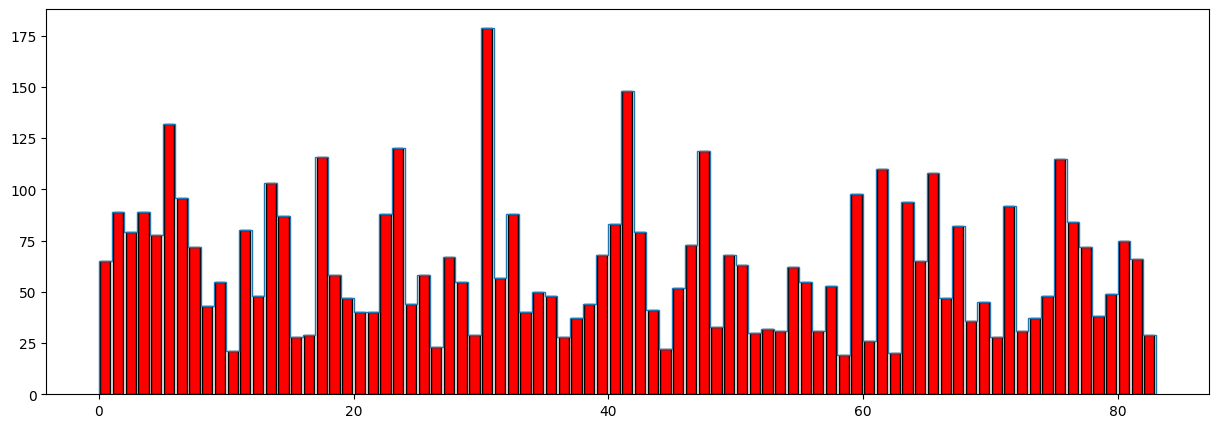

In [11]:
print(kept_res)
fig,axs = plt.subplots(figsize=(15,5),nrows=1)
axs.xaxis.get_majorticklocs()
histdata = axs.hist(kept_res[2], histtype='step', bins=np.arange(0,kept_res[0]+1,1))
# ax.clear()
lblcnts = Counter(kept_res[2])
ordered_cnts = [lblcnts[ii] for ii in range(kept_res[0])]
axs.bar(range(kept_res[0])+0.5*abs(np.diff(histdata[1][:2])), ordered_cnts, color='red', ec='black')

### map these labels back onto the original datasets

In [17]:
product_group_id = [str(i) for i in kept_res[2]]
data = list(zip(unique_descriptions_list, product_group_id))
distinct_descriptions_df = spark.createDataFrame(data, ["description", "product_group_id"])

def map_cluster_ids(original_df, distinct_descriptions_df):
    # Join the original dataset with the distinct descriptions DataFrame on the description column
    mapped_df = original_df.join(distinct_descriptions_df, original_df.Description == distinct_descriptions_df.description, "left") \
                           .select(original_df["*"], distinct_descriptions_df["product_group_id"])
    
    return mapped_df

# Apply the function to map cluster IDs
# s1clean = map_cluster_ids(s1clean, distinct_descriptions_df)

# Show the results
columns_to_select = ['Description','product_group_id']
df_selected = s1clean.select(columns_to_select)
# Show the DataFrame with the selected columns
df_selected.show(30, truncate=200)

+-----------------------------------+----------------+
|                        Description|product_group_id|
+-----------------------------------+----------------+
|      charlotte bagpink/white spots|              66|
|      knitted mug cosy ivory colour|              23|
|            dairy maid pudding bowl|              46|
|          hi tec alpine hand warmer|              20|
|        60 teatime fairy cake cases|              22|
|   glitter hanging butterfly string|              49|
|           vintage design gift tags|              67|
|      wash bag vintage rose paisley|               2|
|           home building block word|              34|
|    assorted tutti frutti round box|              75|
|     girls alphabet iron on patches|              67|
|          assorted tutti frutti pen|              42|
|               door mat new england|              74|
|            magic garden mount fuji|              53|
|          letter "s" bling key ring|              38|
|         

### visualizing cluster results using UMAP

In [28]:
import umap
umap.UMAP?

Init signature:
umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
Docstring:     
Uniform Manifold

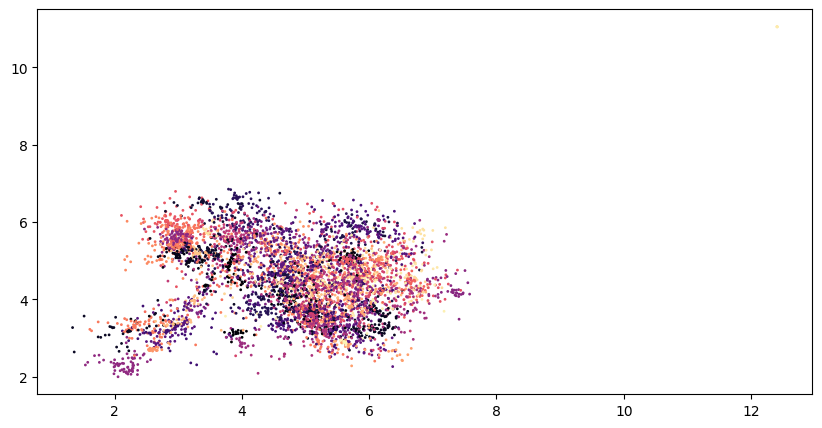

In [67]:
clusterable_embedding = umap.UMAP(
    n_neighbors=25,
    min_dist=0.5,
    n_components=50,
    random_state=42,
    metric='cosine',
    learning_rate=0.1,
    n_epochs=1000,
    densmap=True,
    dens_lambda=3.0,
    dens_frac=0.5,
    n_jobs=6,
    init='pca'
).fit_transform(embeddings)

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=labels, s=1, cmap='magma');

In [76]:
for ii in range(clusterable_embedding.shape[1]):
    print(min(clusterable_embedding[:,ii]), max(clusterable_embedding[:,ii]))

1.3413309 12.4088745
1.9958018 11.047603
1.9847848 8.394028
0.5230189 6.7932177
-0.5051719 7.9465694
3.0294797 11.711826
-0.22227268 7.467591
3.2860882 14.955607
1.9871299 9.827133
1.1575978 9.024367
2.3706007 10.775013
3.7401085 9.097146
2.0711594 9.454241
1.5483788 9.372809
1.3564137 8.189825
-1.9507003 7.0594196
0.010237463 6.5498114
-0.9764855 7.095946
3.287758 10.124061
3.6103277 10.520753
-1.1393371 6.2738824
-3.6840827 6.007896
3.8736835 11.352211
-0.54843915 7.311084
-1.885841 5.62065
-3.8156204 5.691288
0.12072665 5.85649
3.2611737 14.784039
4.1173615 12.886651
-1.9211239 4.560108
3.6891208 10.663384
-2.7678971 5.737706
-2.6006339 6.2219753
3.6580148 11.11994
4.0608764 14.526853
3.214215 9.127597
3.6814973 10.888493
4.0947328 8.547661
-1.1223898 5.9141517
1.0401484 8.860309
0.8013957 6.492766
4.7234693 12.704917
3.9333153 10.873024
0.07737074 7.652869
3.7339132 8.592498
3.3682618 12.577945
1.6277875 6.3252172
1.6296929 7.572219
4.7573195 12.265831
4.8310094 12.773085


In [68]:
g = sns.pairplot(pd.DataFrame(clusterable_embedding), hue_order=kept_res[2])
# g.map(sns.scatterplot)


KeyboardInterrupt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fae583bdfd0>>
Traceback (most recent call last):
  File "/home/lreclusa/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x7fad43484430> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x7fad0057e040> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [75]:
umap_cosines = skl.metrics.pairwise.cosine_similarity(clusterable_embedding)
print(umap_cosines)
with open("umap_cosines.npy",'wb') as f:
    np.save(f, umap_cosines)

[[1.0000001  0.98637843 0.99605334 ... 0.9911603  0.98851234 0.98840624]
 [0.98637843 1.         0.9888214  ... 0.9954833  0.9958666  0.9950066 ]
 [0.99605334 0.9888214  1.         ... 0.99320394 0.9892659  0.9890541 ]
 ...
 [0.9911603  0.9954833  0.99320394 ... 0.9999999  0.99625933 0.99460626]
 [0.98851234 0.9958666  0.9892659  ... 0.99625933 1.0000002  0.99839604]
 [0.98840624 0.9950066  0.9890541  ... 0.99460626 0.99839604 1.0000002 ]]


## RFM analysis of customers across both sheets

In [82]:
s1clean.unionByName(s2clean).show(truncate=False)

+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|489439 |21493    |vintage design gift tags           |12      |2009-12-01 09:28:00|0.85 |12682      |France        |
|489550 |22276    |wash bag vintage rose paisley      |6       |2009-12-01 12:33:00|2.55 |14156      |EIRE          |
|489556 |21491    |three vintage gift wraps           |6       |2009-12-01 12:47:00|1.95 |15719      |United Kingdom|
|489572 |21538    |dairy maid pudding bowl            |2       |2009-12-01 13:29:00|3.75 |17611      |United Kingdom|
|489635 |20682    |red spotty childs umbrella         |6       |2009-12-01 15:26:00|3.25 |16763      |United Kingdom|
|489641 |84991    |60 teatime fairy cake cases        |2

In [111]:
print(s1clean.agg(pysk.sql.functions.min("InvoiceDate")).collect()[0][0].strftime("%B %d, %Y"),s1clean.agg(pysk.sql.functions.max("InvoiceDate")).collect()[0][0].strftime("%B %d, %Y"))
print(s2clean.agg(pysk.sql.functions.min("InvoiceDate")).collect()[0][0].strftime("%B %d, %Y"),s2clean.agg(pysk.sql.functions.max("InvoiceDate")).collect()[0][0].strftime("%B %d, %Y"))  

December 01, 2009 December 09, 2010
December 01, 2010 December 09, 2011


In [112]:
df = s1clean.unionByName(s2clean)
df = df.withColumn('TotalPrice', col('Quantity') * col('Price'))


